# Using Lime with Pytorch

In this tutorial we will show how to use Lime framework with Pytorch. Specifically, we will use Lime to explain the prediction generated by one of the pretrained ImageNet models.

Let's start with importing our dependencies. This code is tested with Pytorch 1.0 but should work with older versions as well.

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json
import pandas as pd
import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

In [2]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import pytorch_lightning as pl
from torch.nn import functional as F
from collections import defaultdict
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from torchvision import models
import torch.nn as nn
import os
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import seaborn as sns
from torchvision.models import ResNet18_Weights
import matplotlib.pyplot as plt
from torchvision import transforms
import json
import numpy as np
from tqdm import tqdm

Load our test image and see how it looks.

In [3]:
DATA_PATH = "/home/alumno/Desktop/datos/cassava"
CSV_FILE = "/home/alumno/Desktop/datos/cassava/cassava_split.csv"
IMAGES_PATH = "/home/alumno/Desktop/datos/cassava/images"
LABELS_FILE = "/home/alumno/Desktop/datos/cassava/label_num_to_disease_map.json"
print(CSV_FILE)

/home/alumno/Desktop/datos/cassava/cassava_split.csv


In [4]:
# Read split CSV + create a filepath column
cassava_df = pd.read_csv(CSV_FILE)
cassava_df["filepath"] = cassava_df.image_id.apply(lambda x: f"{IMAGES_PATH}/{x}")
cassava_df.head()

image_id  label    set  \
0  1584105518.jpg      4  train   
1  4020462779.jpg      1  train   
2  3354881630.jpg      1  train   
3   388811074.jpg      4  train   
4  4255258797.jpg      3  train   

                                            filepath  
0  /home/alumno/Desktop/datos/cassava/images/1584...  
1  /home/alumno/Desktop/datos/cassava/images/4020...  
2  /home/alumno/Desktop/datos/cassava/images/3354...  
3  /home/alumno/Desktop/datos/cassava/images/3888...  
4  /home/alumno/Desktop/datos/cassava/images/4255...

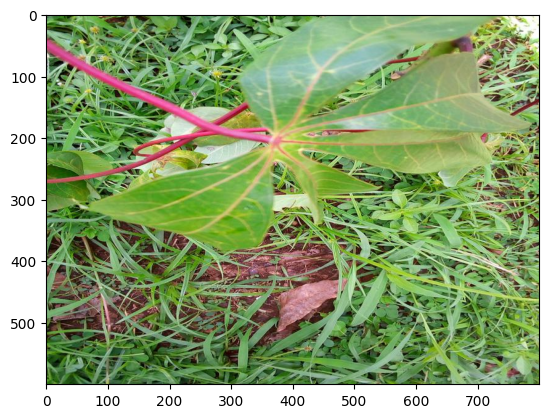

In [5]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
img = get_image(cassava_df.iloc[0]["filepath"])
plt.imshow(img)

We need to convert this image to Pytorch tensor and also apply whitening as used by our pretrained model.

In [6]:
# resize and take the center part of image to what our model expects
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

In [7]:
class CassavaDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        r = self.df.iloc[idx]

        x = Image.open(r.filepath).convert("RGB")
        y = torch.tensor(int(r.label), dtype=torch.long)

        if self.transform:
            x = self.transform(x)

        return x, y

In [23]:
class CassavaDataModule(pl.LightningDataModule):
    def __init__(self, df, bs=64, n_workers=2):
        super().__init__()

        self.df = df
        self.bs = bs
        self.n_workers = n_workers
        # Classes
        with open(LABELS_FILE, "r") as f:
            label_map = json.load(f)
        self.classes = list(label_map.values())

        # ImageNet1K validation transforms
        self.transform = transforms.Compose(
            [
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

    def setup(self, stage: str):
        self.train_ds = CassavaDataset(
            self.df.query('set == "train"'), transform=self.transform
        )
        self.val_ds = CassavaDataset(
            self.df.query('set == "val"'), transform=self.transform
        )
        self.test_ds = CassavaDataset(
            self.df.query('set == "test"'), transform=self.transform
        )

    def train_dataloader(self):
        dataloader = DataLoader(
            self.train_ds, batch_size=self.bs, num_workers=self.n_workers, shuffle=True
        )
        return dataloader

    def val_dataloader(self):
        dataloader = DataLoader(
            self.val_ds, batch_size=self.bs, num_workers=self.n_workers, shuffle=False
        )
        return dataloader

    def test_dataloader(self):
        dataloader = DataLoader(
            self.test_ds, batch_size=self.bs, num_workers=self.n_workers, shuffle=False
        )
        return dataloader

In [24]:
dm = CassavaDataModule(cassava_df, bs=64, n_workers=1)
dm.setup(None)
x, y = next(iter(dm.train_dataloader()))
x.shape, y.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [10]:
class LightningModule(pl.LightningModule):
    def __init__(self, model, lr=1e-3, wd=0.0, discriminative_lr=None):
        super().__init__()
        self.model = model
        self.lr = lr
        self.wd = wd
        self.discriminative_lr = discriminative_lr  # (lr, lr_mult)

        self.training_step_outputs = defaultdict(float)
        self.validation_step_outputs = defaultdict(float)

    def get_layer_wise_lr(self, lr, lr_mult):
        # Save layer names
        layer_names = []
        for idx, (name, param) in enumerate(self.model.named_parameters()):
            layer_names.append(name)
            print(f"{idx}: {name}")

        # Reverse layers
        layer_names.reverse()

        # placeholder
        parameters = []
        prev_group_name = layer_names[0].split(".")[0]

        # store params & learning rates
        for idx, name in enumerate(layer_names):
            # parameter group name
            cur_group_name = name.split(".")[0]

            # update learning rate
            if cur_group_name != prev_group_name:
                lr *= lr_mult
            prev_group_name = cur_group_name

            # display info
            print("Using discriminative learning rates")
            print(f"{idx}: lr = {lr:.6f}, {name}")

            # append layer parameters
            parameters += [
                {
                    "params": [
                        p
                        for n, p in self.model.named_parameters()
                        if n == name and p.requires_grad
                    ],
                    "lr": lr,
                }
            ]

        return parameters

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        return torch.optim.Adam(
            self.parameters()
            if self.discriminative_lr == None
            else self.get_layer_wise_lr(*self.discriminative_lr),
            lr=self.lr,
            weight_decay=self.wd,
        )

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log("train_loss", loss, on_step=False, on_epoch=True)

        self.training_step_outputs["loss"] += loss.detach().cpu()
        self.training_step_outputs["steps"] += 1

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log("val_loss", loss, on_step=False, on_epoch=True)

        self.validation_step_outputs["loss"] += loss.detach().cpu()
        self.validation_step_outputs["steps"] += 1

        return loss

    def on_train_epoch_end(self):
        avg_loss = (
            self.training_step_outputs["loss"] / self.training_step_outputs["steps"]
        )
        print(
            f"Average training loss for epoch {self.current_epoch}: {avg_loss.item():.4f}"
        )
        self.training_step_outputs.clear()

    def on_validation_epoch_end(self):
        avg_loss = (
            self.validation_step_outputs["loss"] / self.validation_step_outputs["steps"]
        )
        print(
            f"Average validation loss for epoch {self.current_epoch}: {avg_loss.item():.4f}"
        )
        self.validation_step_outputs.clear()

In [12]:
pl.seed_everything(seed=42, workers=True)

weights = ResNet18_Weights.IMAGENET1K_V1
model = models.resnet18(weights=weights)

num_in_feat = model.fc.in_features
model.fc = nn.Linear(num_in_feat, 5)

lightning_module = LightningModule(model, discriminative_lr=(1e-3, 0.9))

csv_logger = CSVLogger(save_dir=os.getcwd(), name="cassava_ft_disc_lr")

model_checkpoint_callback = pl.callbacks.model_checkpoint.ModelCheckpoint(
    monitor="val_loss",
    mode="min",
    filename="best_valid_loss",
    verbose=True,
    save_last=False,
)

trainer = pl.Trainer(
    max_epochs=10, logger=csv_logger, callbacks=[model_checkpoint_callback]
)

data_module = CassavaDataModule(df=cassava_df, bs=64, n_workers=8)

trainer.fit(lightning_module, data_module)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params | Mode 
-----------------------------------------
0 | model | ResNet | 11.2 M | train
-----------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.716    Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


0: conv1.weight
1: bn1.weight
2: bn1.bias
3: layer1.0.conv1.weight
4: layer1.0.bn1.weight
5: layer1.0.bn1.bias
6: layer1.0.conv2.weight
7: layer1.0.bn2.weight
8: layer1.0.bn2.bias
9: layer1.1.conv1.weight
10: layer1.1.bn1.weight
11: layer1.1.bn1.bias
12: layer1.1.conv2.weight
13: layer1.1.bn2.weight
14: layer1.1.bn2.bias
15: layer2.0.conv1.weight
16: layer2.0.bn1.weight
17: layer2.0.bn1.bias
18: layer2.0.conv2.weight
19: layer2.0.bn2.weight
20: layer2.0.bn2.bias
21: layer2.0.downsample.0.weight
22: layer2.0.downsample.1.weight
23: layer2.0.downsample.1.bias
24: layer2.1.conv1.weight
25: layer2.1.bn1.weight
26: layer2.1.bn1.bias
27: layer2.1.conv2.weight
28: layer2.1.bn2.weight
29: layer2.1.bn2.bias
30: layer3.0.conv1.weight
31: layer3.0.bn1.weight
32: layer3.0.bn1.bias
33: layer3.0.conv2.weight
34: layer3.0.bn2.weight
35: layer3.0.bn2.bias
36: layer3.0.downsample.0.weight
37: layer3.0.downsample.1.weight
38: layer3.0.downsample.1.bias
39: layer3.1.conv1.weight
40: layer3.1.bn1.weight
4

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/alumno/py313ml/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Average validation loss for epoch 0: 1.3645


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 235: 'val_loss' reached 0.61639 (best 0.61639), saving model to '/home/alumno/Downloads/vision/cassava_ft_disc_lr/version_20/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 0: 0.6094
Average training loss for epoch 0: 0.6903


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 470: 'val_loss' reached 0.60363 (best 0.60363), saving model to '/home/alumno/Downloads/vision/cassava_ft_disc_lr/version_20/checkpoints/best_valid_loss.ckpt' as top 1


Average validation loss for epoch 1: 0.5976
Average training loss for epoch 1: 0.5318


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 705: 'val_loss' was not in top 1


Average validation loss for epoch 2: 0.7106
Average training loss for epoch 2: 0.4442


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 940: 'val_loss' was not in top 1


Average validation loss for epoch 3: 0.7403
Average training loss for epoch 3: 0.3513


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 1175: 'val_loss' was not in top 1


Average validation loss for epoch 4: 0.7010
Average training loss for epoch 4: 0.2930


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 1410: 'val_loss' was not in top 1


Average validation loss for epoch 5: 0.6755
Average training loss for epoch 5: 0.2241


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 1645: 'val_loss' was not in top 1


Average validation loss for epoch 6: 0.8691
Average training loss for epoch 6: 0.1767


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 1880: 'val_loss' was not in top 1


Average validation loss for epoch 7: 1.0982
Average training loss for epoch 7: 0.2139


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 2115: 'val_loss' was not in top 1


Average validation loss for epoch 8: 0.8016
Average training loss for epoch 8: 0.1129


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 2350: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


Average validation loss for epoch 9: 1.0502
Average training loss for epoch 9: 0.0590


Load the pretrained model for Resnet50 available in Pytorch.

Load label texts for ImageNet predictions so we know what model is predicting

In [13]:
idx2label, cls2label, cls2idx = [], {}, {}
with open(os.path.abspath(LABELS_FILE), 'r') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}    

Get the predicition for our image.

In [14]:
img_t = get_input_tensors(img)
model.eval()
logits = model(img_t)

Predicitions we got are logits. Let's pass that through softmax to get probabilities and class labels for top 5 predictions.

In [15]:
probs = F.softmax(logits, dim=1)
probs5 = probs.topk(5)
tuple((p,c, idx2label[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))

((np.float32(0.9116033), np.int64(2), 'C'),
 (np.float32(0.06982665), np.int64(4), 'e'),
 (np.float32(0.017740285), np.int64(1), 'C'),
 (np.float32(0.00054181437), np.int64(0), 'C'),
 (np.float32(0.0002879652), np.int64(3), 'C'))

We are getting ready to use Lime. Lime produces the array of images from original input image by pertubation algorithm. So we need to provide two things: (1) original image as numpy array (2) classification function that would take array of purturbed images as input and produce the probabilities for each class for each image as output. 

For Pytorch, first we need to define two separate transforms: (1) to take PIL image, resize and crop it (2) take resized, cropped image and apply whitening.

In [16]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

Now we are ready to define classification function that Lime needs. The input to this function is numpy array of images where each image is ndarray of shape (channel, height, width). The output is numpy aaray of shape (image index, classes) where each value in array should be probability for that image, class combination.

In [17]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

Let's test our function for the sample image.

In [18]:
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()

np.int64(2)

In [19]:
model = LightningModule.load_from_checkpoint(
    model_checkpoint_callback.best_model_path, model=model
)
model.cuda(0)

y_trues, y_hats = [], []

for x, y_true in iter(data_module.test_dataloader()):
    with torch.no_grad():
        y_hat_logits = model(x.cuda())
        y_hat = nn.Softmax(1)(y_hat_logits).argmax(1)
        y_hat = y_hat.detach().cpu()

    y_hats.append(y_hat)
    y_trues.append(y_true)

y_trues = torch.cat(y_trues)
y_hats = torch.cat(y_hats)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

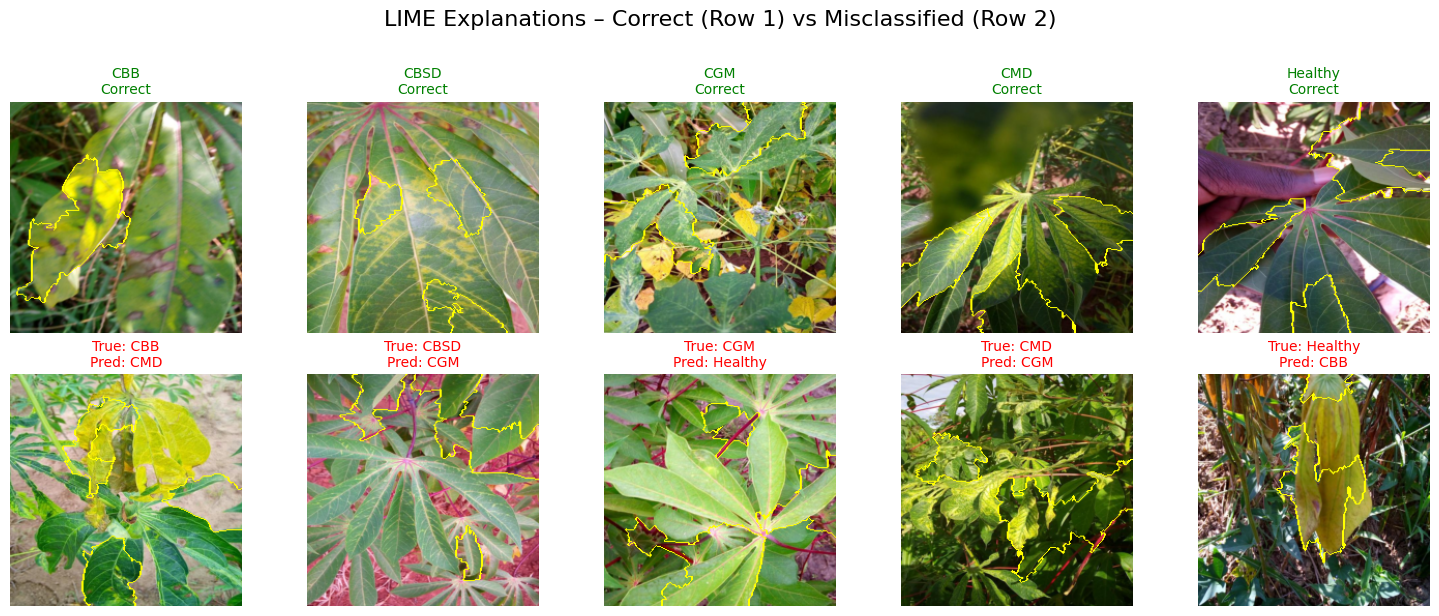

In [37]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries

short_names = ["CBB", "CBSD", "CGM", "CMD", "Healthy"]

def display_all_classes_one_plot(data_module, y_trues, y_hats):
    """
    Create ONE single plot containing all classes in a 5x2 grid.
    Columns: Classes
    Row 0: Correctly classified example
    Row 1: Misclassified example
    """
    
    # Prepare dataset and explainer
    dataset = data_module.test_dataloader().dataset
    explainer = lime_image.LimeImageExplainer()

    num_classes = len(short_names)
    # 2 rows (Correct, Misclassified), 5 columns (Classes)
    fig, axes = plt.subplots(2, num_classes, figsize=(num_classes * 3, 6))
    fig.suptitle(
        "LIME Explanations – Correct (Row 1) vs Misclassified (Row 2)",
        fontsize=16,
        y=1.02
    )

    # Ensure axes always 2D
    if num_classes == 1:
        axes = axes.reshape(2, 1)

    for class_id in range(num_classes):
        class_name = short_names[class_id]

        # Find indices
        correct_idx = ((y_trues == class_id) & (y_hats == class_id)).nonzero(as_tuple=True)[0]
        miscls_idx = ((y_trues == class_id) & (y_hats != class_id)).nonzero(as_tuple=True)[0]

        # -------- Correct example (Row 0) --------
        ax_corr = axes[0, class_id]
        if len(correct_idx) > 0:
            idx = correct_idx[0]
            img_path = dataset.df.iloc[int(idx)]["filepath"]
            img = get_image(img_path)

            explanation = explainer.explain_instance(
                np.array(pill_transf(img)),
                batch_predict,
                top_labels=1,
                hide_color=0,
                num_samples=1000
            )

            temp, mask = explanation.get_image_and_mask(
                explanation.top_labels[0],
                positive_only=True,
                num_features=5,
                hide_rest=False
            )

            img_ready = mark_boundaries(temp / 255.0, mask)
            ax_corr.imshow(img_ready)
            ax_corr.set_title(f"{class_name}\nCorrect", color="green", fontsize=10)
        else:
            ax_corr.text(0.5, 0.5, "None", ha='center', va='center')
            ax_corr.set_title(f"{class_name}", fontsize=10)
        
        ax_corr.axis("off")

        # -------- Misclassified example (Row 1) --------
        ax_misc = axes[1, class_id]
        if len(miscls_idx) > 0:
            idx = miscls_idx[0]
            img_path = dataset.df.iloc[int(idx)]["filepath"]
            img = get_image(img_path)

            true_label = y_trues[idx].item()
            pred_label = y_hats[idx].item()

            explanation = explainer.explain_instance(
                np.array(pill_transf(img)),
                batch_predict,
                top_labels=1,
                hide_color=0,
                num_samples=1000
            )

            temp, mask = explanation.get_image_and_mask(
                explanation.top_labels[0],
                positive_only=True,
                num_features=5,
                hide_rest=False
            )

            img_ready = mark_boundaries(temp / 255.0, mask)
            ax_misc.imshow(img_ready)
            ax_misc.set_title(
                f"True: {short_names[true_label]}\nPred: {short_names[pred_label]}",
                color="red",
                fontsize=10,
            )
        else:
            ax_misc.text(0.5, 0.5, "None", ha='center', va='center')
        
        ax_misc.axis("off")

    plt.tight_layout()
    plt.show()

display_all_classes_one_plot(dm, y_trues, y_hats)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

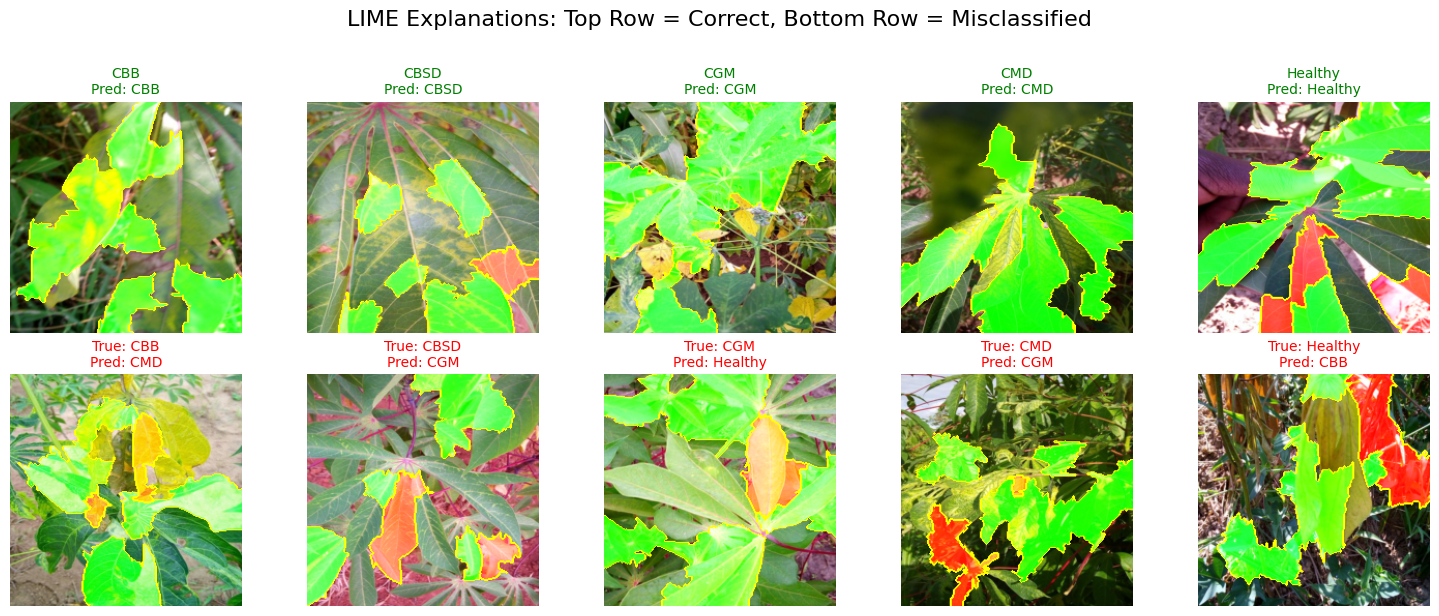

In [34]:
# --- Short class names ---
short_names = ["CBB", "CBSD", "CGM", "CMD", "Healthy"]

def display_examples_from_module(data_module, y_trues, y_hats):
    """
    Display correctly classified and misclassified images per class from a LightningDataModule
    in a single 5x2 grid (Columns: Classes, Rows: Correct/Misclassified).
    """
    # Indices
    correct_mask = (y_trues == y_hats)
    misclassified_mask = (y_trues != y_hats)

    dataset = data_module.test_dataloader().dataset
    explainer = lime_image.LimeImageExplainer()
    
    num_classes = len(short_names)

    # 2 rows (Correct, Misclassified), 5 columns (Classes)
    fig, axes = plt.subplots(2, num_classes, figsize=(num_classes * 3, 6))
    fig.suptitle("LIME Explanations: Top Row = Correct, Bottom Row = Misclassified", fontsize=16, y=1.02)

    for class_id in range(num_classes):
        class_name = short_names[class_id]

        # Filter indices for this class
        correct_class_idx = ((y_trues == class_id) & correct_mask).nonzero(as_tuple=True)[0]
        misclassified_class_idx = ((y_trues == class_id) & misclassified_mask).nonzero(as_tuple=True)[0]

        # --- Row 0: Correctly Classified ---
        ax_corr = axes[0, class_id]
        if len(correct_class_idx) > 0:
            idx = correct_class_idx[0]
            # Use dataset.df to get the correct filepath for the test set index
            img_path = dataset.df.iloc[int(idx)]["filepath"]
            img = get_image(img_path)
            
            explanation = explainer.explain_instance(
                np.array(pill_transf(img)), 
                batch_predict, 
                top_labels=5, 
                hide_color=0, 
                num_samples=1000
            )
            temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
            img_boundry = mark_boundaries(temp/255.0, mask)
            
            ax_corr.imshow(img_boundry)
            pred_label = y_hats[idx].item()
            ax_corr.set_title(f"{class_name}\nPred: {short_names[pred_label]}", color="green", fontsize=10)
        else:
            ax_corr.text(0.5, 0.5, "None", ha='center', va='center')
            ax_corr.set_title(f"{class_name}", fontsize=10)
        ax_corr.axis("off")

        # --- Row 1: Misclassified ---
        ax_misc = axes[1, class_id]
        if len(misclassified_class_idx) > 0:
            idx = misclassified_class_idx[0]
            img_path = dataset.df.iloc[int(idx)]["filepath"]
            img = get_image(img_path)
            true_label = y_trues[idx].item()
            
            explanation = explainer.explain_instance(
                np.array(pill_transf(img)), 
                batch_predict, 
                top_labels=5, 
                hide_color=0, 
                num_samples=1000
            )
            temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
            img_boundry = mark_boundaries(temp/255.0, mask)
            
            ax_misc.imshow(img_boundry)
            pred_label = y_hats[idx].item()
            ax_misc.set_title(f"True: {short_names[true_label]}\nPred: {short_names[pred_label]}", color="red", fontsize=10)
        else:
            ax_misc.text(0.5, 0.5, "None", ha='center', va='center')
        ax_misc.axis("off")

    plt.tight_layout()
    plt.show()

# --- Example usage ---
display_examples_from_module(dm, y_trues, y_hats)

Import lime and create explanation for this prediciton.

In [26]:
from lime import lime_image

In [27]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

  0%|          | 0/1000 [00:00<?, ?it/s]

Let's use mask on image and see the areas that are encouraging the top prediction.

In [28]:
from skimage.segmentation import mark_boundaries

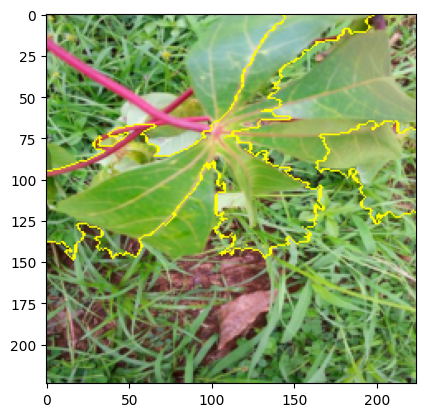

In [29]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

Let's turn on areas that contributes against the top prediction.

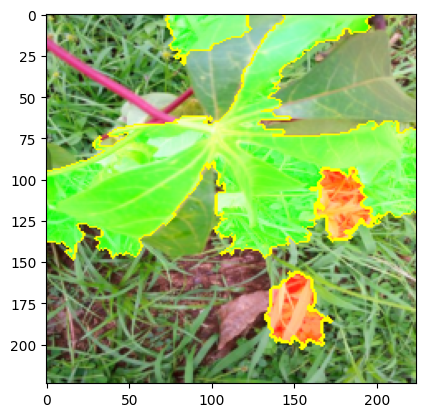

In [30]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)